In [1]:
import numpy as np
from numpy.fft import fft, ifft
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy import signal
import import_ipynb
from Helpers import *
import matplotlib
from IPython.display import IFrame

figsize=(10,5)
matplotlib.rcParams.update({'font.size': 16})

fs=44100

importing Jupyter notebook from Helpers.ipynb


## 2.? Neural nets??

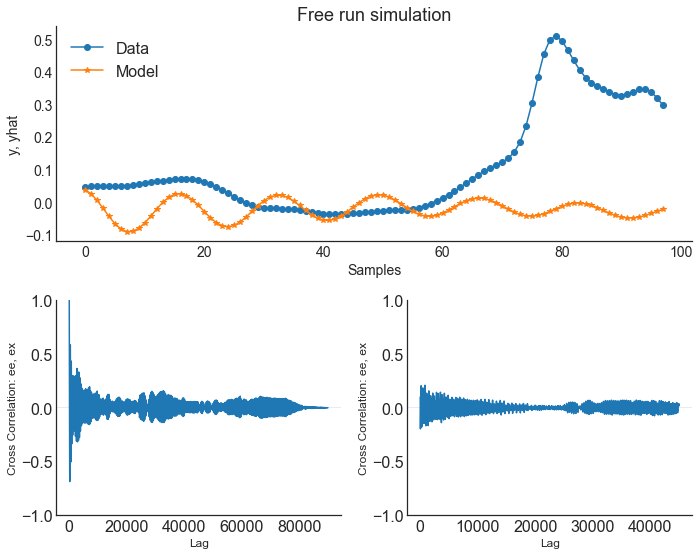

In [85]:
from torch import nn
from sysidentpy.neural_network import NARXNN

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

narx_net = NARXNN(net=NARX(),
                  ylag=2,
                  xlag=2,
                  loss_func='mse_loss',
                  optimizer='Adam',
                  epochs=200,
                  verbose=False,
                  optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

train_dl = narx_net.data_transform(x_train.reshape(-1,1), y_train.reshape(-1,1))
valid_dl = narx_net.data_transform(x_valid, y_valid)
narx_net.fit(train_dl, valid_dl)
yhat = narx_net.predict(x_valid, y_valid)
ee, ex, extras, lam = narx_net.residuals(x_valid, y_valid, yhat)
narx_net.plot_result(y_valid, yhat, ee, ex)

In [86]:
predict = narx_net.predict(guitar_sample[200000:210000].reshape(-1, 1), guitar_sample[199000:200000].reshape(-1,1))

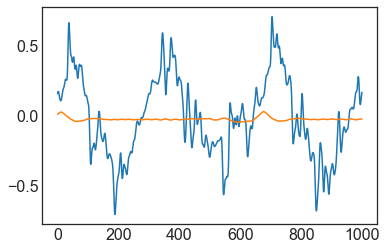

In [87]:
plt.plot(guitar_wh[201000:202000])
plt.plot(predict[1000:2000])

In [88]:
write_audio(predict, "samples/guitar_NN.wav")

## 3. Identification using Volterrra kernels

**TODO: fix this??**

In [26]:
# Constants

p=5 # Maximum degree of the Volterra series
N=500 # test size

In [27]:
x_train = guitar_sample[200000:200000+N]
y_train = wiener_hammerstein(guitar_sample, 15, IR_preamp, IR_cab)[200000:200000+N]

### 3.1. Training the Volterra kernels

In [28]:
def a(n):
    return np.sqrt(1/math.factorial(n))

def kp(x1, x2):
    return np.sum( np.fromiter( (a(n)**2 * (x1*x2)**n for n in range(0,p) ), float) )

kp_vec = np.vectorize(kp, excluded=["x1"])

def kpVec(xnew, x):
    return (kp_vec(xnew, x)).T

In [29]:
# Global computation of the Gram Matrix K
Kp = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        Kp[i,j] = kp(x_train[i], x_train[j])
        
KpInv = np.linalg.pinv(Kp)

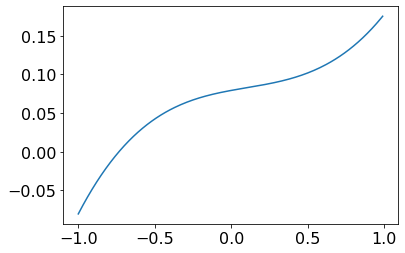

In [30]:
def volterraEstimation(newx, x, y):
    
    return y.T @ KpInv @ kpVec(newx, x)

plt.plot( np.arange(-1,1,0.01), [volterraEstimation(i, x_train, y_train) for i in np.arange(-1,1,0.01)])

In [31]:
def volterraFilter(x):
    y = np.zeros(x.size)
    
    for i in range(x.size):
        y[i] = volterraEstimation(x[i], x_train, y_train)
        
    return y

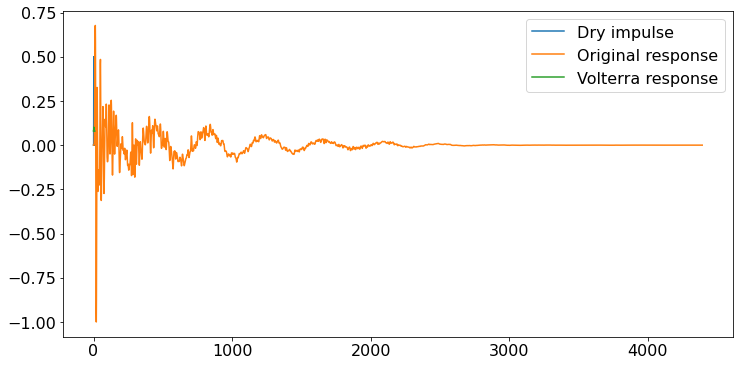

In [32]:
impulse = np.zeros(10)
impulse[2] = .5

originalImpulseResponse = wiener_hammerstein(impulse, 5, IR_preamp, IR_cab)
volterraImpulseResponse = volterraFilter(impulse)

plt.figure(figsize=(12,6))
plt.plot(impulse, label='Dry impulse')
plt.plot(originalImpulseResponse, label='Original response')
plt.plot(volterraImpulseResponse, label='Volterra response')
plt.legend(loc="best")
plt.show()

### 3.2. Test with actual guitar

In [33]:
guitar_disto_volterra = volterraFilter(guitar_sample)

KeyboardInterrupt: 

In [ ]:
write_audio(guitar_disto_volterra, "samples/guitar_disto_volterra.wav")